# Homework 1

First name:

Last name:


---

The two exercises follow each other.

You will probably need to use an optimization library (like `Optim.jl`) and a differentiation library (`Forward.jl` or `Zygote.jl`) as well as a plotting library (`Plots.jl` or `SimplePlots.jl`) but feel free to install other libraries you might find useful.

You must send me your work before May 16th. You can send it on zulip or to `pwinant@escp.eu` with subject starting by `[eco309]`.

Don't hesitate to ask questions or help each other. Copying/pasting code is forbidden though.

---

## Solow model

This model tries to explain long-term growth, its relation to productivity, population growth and the speed of convergence.

The setup is the following:

- a country accumulates capital $k_t$
- population $n_t$ grows at rate $g$ (so that $n_{t+1}=g n_t$)
- capital and labour are combined to produce $y_t = A F(k_t, n_t)$ where $A>0$ is total factor productivity.
- capital depreciates at rate $\delta \in ]0,1[$. Its law of motion is $k_{t+1}=(1-\delta)k_{t}+i_{t}$ where $i_t$ is the amount invested at time $t$
- production is either consumed or invested: $y_t = c_t + i_t$

We choose a Cobb-Douglas specification with constant returns to scale $F(k_t, n_t) = k_t^{\alpha} n_t^{1-\alpha}$.


Here we follow the Solow-Swan specification and make the simplifying assumption that there is a fixed fraction $s\in[0,1[$ of income, which is saved and invested in every period. In other words investment (or savings) is given by:

$$i_t = s y_t$$

As a result, the dynamic of capital and all other variables will be backward looking and can be simulated easily.

__Create a dictionary to hold parameter values.__

 (note: such a dictionary can be defined as `p = Dict(:a=>0.9, :b=>4)` and accessed with brackets `p[:a]` or `p[:b]`) (note2: symbols like `:a` or `:b` are lightweight string. The content must be a valid julia identifier so that it is valid to write `a=p[:a]`)

In [1]:
# We'll create a dictionary of parameters
p = Dict(
    :A=> 1.0,
    :α=>0.3, # capital share (30%)
    :β=>0.96, # (1/r): 1/1.04
    :δ=>0.1,  # depreciation rate of capital: literature
    :g=>1.01, # growth rate of population: Census
    :s=>0.2   # saving rate from national accounts (Y-C)/Y
)

Dict{Symbol, Float64} with 6 entries:
  :α => 0.3
  :A => 1.0
  :s => 0.2
  :δ => 0.1
  :g => 1.01
  :β => 0.96

__Detrend the equations of the model w.r.t. population growth. Denote the detrended variables with a hat (in the code we assume all variables are detrended and ignore the hat).__

Our goal is to compute the steady-state and assess its stability.

__Compute a function `f` which returns the capital $\hat{k}_{t+1}$ as a function of $\hat{k_t}$. It is suggested to define `f(k::Float64, p::Dict{Symbol, Float64})` where `p` is a dictionary of parameters.__

In [37]:
function f(k  ; p::Dict{Symbol, Float64})
    y = p[:A]*k^(p[:α])
    i = p[:s]*y
    K = ((1-p[:δ])*k + i)/p[:g]
    return K
end

f (generic function with 1 method)

In [39]:
f(5; p=p)

4.776367642909458

__Starting from an initial level $\hat{k}_0$ compute successive iterates of `f` to find the long-run level $\overline{k}$ of capital per capita. (Bonus: produce a nice plot of the convergence)__

In [40]:
function simulate(k0, p, T=100)
    ksim = [k0]
    for t=1:T
        k = ksim[end]
        K = f(k; p=p)
        push!(ksim, K)
    end
    return ksim
end


simulate (generic function with 2 methods)

In [41]:
sim = simulate(0.5, p, 100);

In [42]:
using Plots

In [43]:
kvec = range(0.0, 6; length=100)
fvec = f.(kvec; p);

In [44]:
hz_segments = [ ( (a, b)) for (a,b) in zip(sim[1:end-1], sim[2:end])];

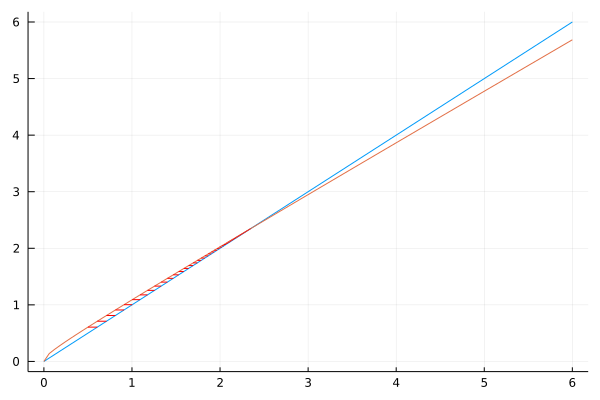

In [45]:
pl = plot(kvec, kvec)
plot!(pl, kvec, fvec)
for (a,b) in hz_segments
    plot!(pl, [a,b],[b,b], color=:red, legend=false)
end
pl

__Propose and implement a way to accelerate convergence__

In [ ]:
#  Aitkens' extrapolation

__What factors affect the steady-state level of capital?__

In [53]:
function steady_state(p::Dict{Symbol, Float64}, k0=1; T=100, tol_η=1e-6)
    for t=1:T
        K = f(k0; p=p)
        if abs(K-k0)<tol_η
            return K
        end
        k0 = K
    end
    return k0
end

steady_state (generic function with 2 methods)

In [54]:
steady_state(p, 1.0)

2.3485992665572386

In [59]:
gvec = range(1.0, 1.05; length=6)
kbar_g = []
for g in gvec
    p0 = copy(p)
    p0[:g] = g
    kbar = steady_state(p0, 1.0)
    push!(kbar_g, kbar)
    
end
plot(gvec, kbar_g, xlabel="g", ylabel="k/n")

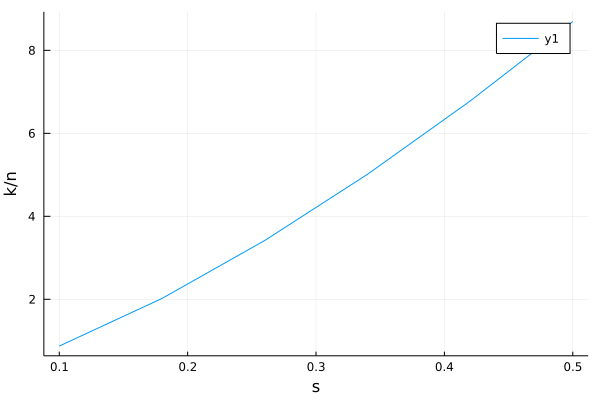

In [64]:
svec = range(0.1, 0.5; length=6)
kbar_s = []
for s in svec
    p0 = copy(p)
    p0[:s] = s
    kbar = steady_state(p0, 1.0)
    push!(kbar_s, kbar)
    
end
plot(svec, kbar_s, xlabel="s", ylabel="k/n")

__Study the stability of $f$ around $\overline{k}$ (hint: compute the right derivative). Which factors affect the speed of convergence towards the steady-state?__

You study the sequence $k_t = f(k_{t-1})$ around steady state. Define $\lambda=f^{\prime}(\overline{k}$).
Convergence, is geometric with rate $\lambda$. In particular, it converges if $|\lambda|<1$


In [67]:
# we can differentiate automatically functions, whose arguments derive from Number

function f(k::Number  ; p::Dict{Symbol, Float64})
    y = p[:A]*k^(p[:α])
    i = p[:s]*y
    K = ((1-p[:δ])*k + i)/p[:g]
    return K
end

f (generic function with 2 methods)

In [70]:
using ForwardDiff

In [75]:
# when arguements derive from Number
# they can be replaced with Dual numbers
# which allows for automatic differentiation
k_dual = ForwardDiff.Dual(4., 1)
f(k_dual; p=p)

Dual{Nothing}(3.8644983300020592,0.9135997509877781)

In [83]:
ForwardDiff.derivative(u->f(u;p=p), 5.0)

0.9103444348121912

In [84]:
# stability of the steady-state
λ(p::Dict) = ForwardDiff.derivative(u->f(u;p=p), steady_state(p, 1.0))

λ (generic function with 2 methods)

In [85]:
λ(p)

0.923767723171523

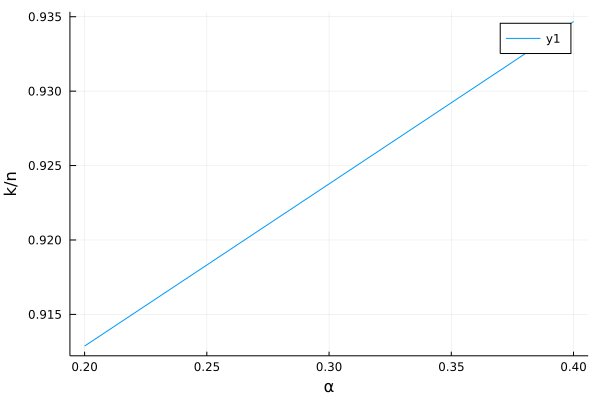

In [88]:
# how does λ depend on the saving rate ?

avec = range(0.2, 0.4; length=6)
kbar_a = []
λ_a = []
for a in avec
    p0 = copy(p)
    p0[:α] = a
    kbar = steady_state(p0, 1.0)
    lam = λ(p0)
    push!(kbar_a, kbar)
    push!(λ_a, lam)
    
end
plot(avec, λ_a, xlabel="α", ylabel="k/n")

__Compute the steady-state directly using a Newton method and compare convergence speed.__

In [91]:
]add NLsolve

In [92]:
using NLsolve

In [97]:
res = NLsolve.nlsolve(u->[f(u[1];p)-u[1]], [1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0]
 * Zero: [2.3491483500161667]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

__Suppose one tries to maximize steady-state consumption by choosing saving rate $s$. Which value would one choose?__

In [98]:
function steady_state_consumption(p::Dict)
    kbar = steady_state(p)
    ybar = p[:A]*kbar^p[:α]
    ibar = p[:s]*ybar
    cbar = ybar - ibar
    return cbar
    
end

steady_state_consumption (generic function with 1 method)

In [115]:
function steady_state_consumption(s::Float64; p=Dict())
    p0 = copy(p)
    p0[:s] = s
    return steady_state_consumption(p0)
end
function steady_state(s::Float64; p=Dict())
    p0 = copy(p)
    p0[:s] = s
    return steady_state(p0, 1.0)
end

steady_state (generic function with 3 methods)

In [123]:

svec = range(0.1, 0.5; length=100);
cvec = [steady_state_consumption(e; p=p) for e in svec];
ivec = [steady_state(e; p=p)*p[:δ]/p[:g] for e in svec];

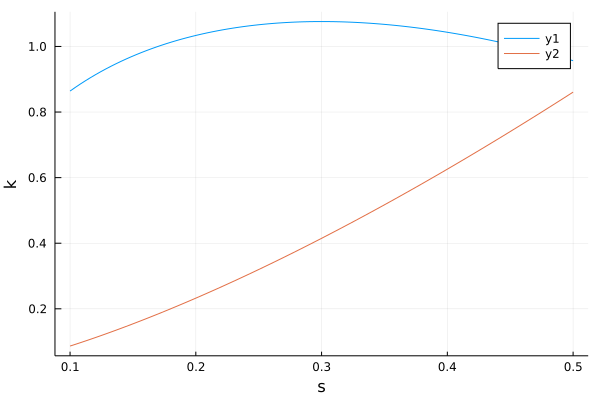

In [124]:
pl = plot(svec, cvec;xlabel="s", ylabel="c")
plot!(pl, svec, ivec;xlabel="s", ylabel="k")

__(Bonus) Suppose an agent is given the intertemporal utility from the Ramsey–Cass–Koopmans model see exercise 2) but chooses saving rate once for all. Which saving rate would one choose to maximize intertemporal utility? Is it the same for all initial levels of capital?__



## Deterministic Neoclassical Model: bruteforce

In the Ramsey–Cass–Koopmans  model (also called neoclassical growth model), a representative agent chooses $c_t$ in every period so as to maximize an intertemporal utility like $\sum_{t \geq 0} \beta^t U(c_t)$ where $\beta \in [0,1[$ is a time discount and $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ is the instantaneous felicity.

The setup is exactly the same as in the the Solow model form session 3, but now we look for a time-dependent saving rule, that is a different $s_t \in [0,1[$ for each date. We will try to choose $s_t$ to maximize

$$\sum_{t = 0}^T \beta^t U(c_t) + \sum_{t = T+1}^{\infty} \beta^t U(c_T) $$


We need to choose vector $\mathbf{s} = (s_0, s_1, ... s_T)$ to maximize intertemporal utility. We can assume $\forall t>T s_t= s_T$


In this exercise, we want to define a function `objective(s::AbstractVector)` and maximize objective numerically using a numerical optimization algorithm.


__Explain why the second term is important__

__Choose an horizon $T$ and write a function `objective(s::AbstractVector, k0::Float64, T::Int, p::Dict{Symbol, Float64})` to compute the objective approximated with $T$ periods as a function of initial state `k0::Float64` and of the vector of saving rates `s::Vector` representing $(s_0, s_1, \cdots s_{T})$. Note that argument type of `s` is left unspecified to make it compatible with automatic differentiation.__

In [ ]:
objective(s; k0, ....)
G  = ForwardDiff.gradient(u->objective(u, k0, ....), )

__Use library `Optim.jl` to maximize the utility function. If possible, find a way to specify exact derivatives of the objective function.__